In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from datetime import datetime

# 1) Loading the dataset
Loading the dataset and removing columns that are not needed.

In [2]:
# load the ED visits dataset with all the features
df_event_log_visits = pd.read_csv('df_visits_dur_timeofday.csv')

In [3]:
# dropping columns that were added earlier for analytics
df_event_log_visits.drop(['Duration', 'Duration_seconds', 'Earliest_Time'], axis=1, inplace=True)

In [4]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301212 entries, 0 to 301211
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301212 non-null  object 
 1   SEX                      301212 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           300415 non-null  object 
 5   FACILITY_ID              301212 non-null  object 
 6   FACILITY_NAME            301212 non-null  object 
 7   VISIT_ID                 301212 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     298986 non-null  float64
 10  DEPART_DISPOSITION_ID    300782 non-null  object 
 11  DEPART_DISPOSITION_DESC  300782 non-null  object 
 12  Activity                 301212 non-null  object 
 13  Start_Time               301212 non-null  object 
 14  End_

In [5]:
# Rename the Start_Time column to Activity_End_Time - there is only one time stamp in the dataset which is assumed to be
# when the activity finished
df_event_log_visits.rename(columns={'Start_Time': 'Activity_End_Time'}, inplace=True)

# Drop the End_Time column
df_event_log_visits.drop(columns=['End_Time'], inplace=True)


In [6]:

# Sort the DataFrame by VISIT_ID and Activity_End_Time
df_event_log_visits.sort_values(by=['VISIT_ID', 'Activity_End_Time'], inplace=True)

# Infer Start_Time for each activity using the Activity_End_Time of the previous activity
df_event_log_visits['Start_Time'] = df_event_log_visits['Activity_End_Time'].shift(1)

# Ensure that the Start_Time is not carried over from the last activity of the previous VISIT_ID to the first activity of the next VISIT_ID
df_event_log_visits.loc[df_event_log_visits['VISIT_ID'] != df_event_log_visits['VISIT_ID'].shift(1), 'Start_Time'] = pd.NaT

# For the first activity in each sequence, set Start_Time equal to Activity_End_Time, indicating zero duration
df_event_log_visits.loc[df_event_log_visits['Start_Time'].isna(), 'Start_Time'] = df_event_log_visits['Activity_End_Time']


In [7]:
# these are the remaining columns in the dataset as of now
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301212 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301212 non-null  object 
 1   SEX                      301212 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           300415 non-null  object 
 5   FACILITY_ID              301212 non-null  object 
 6   FACILITY_NAME            301212 non-null  object 
 7   VISIT_ID                 301212 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     298986 non-null  float64
 10  DEPART_DISPOSITION_ID    300782 non-null  object 
 11  DEPART_DISPOSITION_DESC  300782 non-null  object 
 12  Activity                 301212 non-null  object 
 13  Activity_End_Time        301212 non-null  object 
 14  Durat

In [8]:

# filterinng out the columns I move to the end
columns = list(df_event_log_visits.columns)
columns.remove('Activity_End_Time')
columns.remove('Duration_hours')


# Appending them
columns = columns + ['Activity_End_Time', 'Duration_hours']

# Reordring based on the new column order
df_event_log_visits = df_event_log_visits[columns]

df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,DEPART_DISPOSITION_DESC,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours
35406,STDY147061,F,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,DISCHARGED W/O SUPPORT SERV,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000
35407,STDY147061,F,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,DISCHARGED W/O SUPPORT SERV,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000
35408,STDY147061,F,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,DISCHARGED W/O SUPPORT SERV,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000
35409,STDY147061,F,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,DISCHARGED W/O SUPPORT SERV,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000
213493,STDY321073,M,1999-02-08,NaN,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,D,DISCHARGED W/O SUPPORT SERV,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333


# 2) Dealing with missing values

## DOB

In [9]:
# DOB is the first column with missing values - there are in total for rows 4 missing values - these rows can be droppped

#  Removing records with missing DOB
df_event_log_visits = df_event_log_visits.dropna(subset=['DOB'])

df_event_log_visits.info()



# Next is DOD, however the missing value in this case indicates that the patient is still alive, hence getting rid of these values 
# would lead to losing important information - this column will be dealt with in later step.


<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301208 non-null  object 
 1   SEX                      301208 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           300411 non-null  object 
 5   FACILITY_ID              301208 non-null  object 
 6   FACILITY_NAME            301208 non-null  object 
 7   VISIT_ID                 301208 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     298982 non-null  float64
 10  DEPART_DISPOSITION_ID    300778 non-null  object 
 11  DEPART_DISPOSITION_DESC  300778 non-null  object 
 12  Activity                 301208 non-null  object 
 13  TIME_OF_THE_DAY          301208 non-null  object 
 14  Start

## POSTAL_CODE

In [10]:
# Another column with missing values is the postal code, in this case I decided to fill in the values based on the value of the hospital
# that the patient visited

# Filtering the df to only include rows where ED_POSTAL_CODE is missing
missing_postal_code = df_event_log_visits[df_event_log_visits['ED_POSTAL_CODE'].isnull()]

# Printing the rows with missing ED_POSTAL_CODE
print(missing_postal_code)

               SID SEX         DOB  DOD ED_POSTAL_CODE FACILITY_ID  \
293718  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293719  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293720  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293721  STDY765453   M  1990-08-22  NaN            NaN         GBC   
293655  STDY765432   M  1958-07-25  NaN            NaN         SCM   
...            ...  ..         ...  ...            ...         ...   
301203  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301204  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301205  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301206  STDY768042   F  1976-12-17  NaN            NaN         SCM   
301207  STDY768042   F  1976-12-17  NaN            NaN         SCM   

                                         FACILITY_NAME      VISIT_ID  \
293718  Dr. G.B. Cross Memorial Hospital - Clarenville  VISIT2212299   
293719  Dr. G.B

In [11]:
# Counting occurrences of each FACILITY_ID in the DataFrame with missing postal codes
facility_counts = missing_postal_code['FACILITY_ID'].value_counts()

# Printing the counts
print(facility_counts)


FACILITY_ID
HSC    414
SCM    220
GBC    111
CGH     41
BUR     11
Name: count, dtype: int64


In [12]:
facility_postal_map = {
    'HSC': 'A1B 3V6',
    'GBC': 'A5A 1K3',
    'SCM': 'A1C 5B8',
    'BUR': 'A0E 1E0',
    'CGH': 'A1Y 1A4'
}

# Applying the map to the 'FACILITY_ID' column to create a new 'Imputed_Postal_Code' column
df_event_log_visits['Imputed_Postal_Code'] = df_event_log_visits['FACILITY_ID'].map(facility_postal_map)

# Filling missing 'ED_POSTAL_CODE' values with the imputed values from 'Imputed_Postal_Code'
df_event_log_visits['ED_POSTAL_CODE'].fillna(df_event_log_visits['Imputed_Postal_Code'], inplace=True)

# dropping the column
df_event_log_visits.drop('Imputed_Postal_Code', axis=1, inplace=True)


In [13]:
# Checking if there are any remaining missing values in 'ED_POSTAL_CODE'
print(df_event_log_visits['ED_POSTAL_CODE'].isnull().sum())


0


In [14]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301208 non-null  object 
 1   SEX                      301208 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           301208 non-null  object 
 5   FACILITY_ID              301208 non-null  object 
 6   FACILITY_NAME            301208 non-null  object 
 7   VISIT_ID                 301208 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     298982 non-null  float64
 10  DEPART_DISPOSITION_ID    300778 non-null  object 
 11  DEPART_DISPOSITION_DESC  300778 non-null  object 
 12  Activity                 301208 non-null  object 
 13  TIME_OF_THE_DAY          301208 non-null  object 
 14  Start

## CTAS

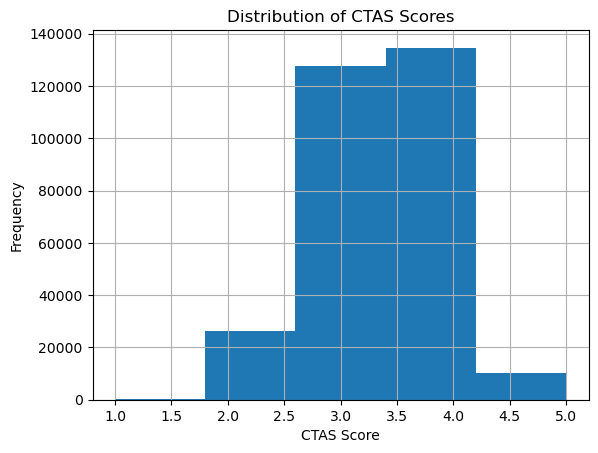

count    298982.000000
mean          3.430344
std           0.702471
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: CTAS, dtype: float64


In [15]:
# Next missing values are in the case of CTAS column 

# Histogram to see the distribution of CTAS scores
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

# Descriptive statistics
print(df_event_log_visits['CTAS'].describe())


In [16]:
# Check for rows where CTAS is missing
missing_ctas_df = df_event_log_visits[df_event_log_visits['CTAS'].isna()]

# Display how many of these have 'TLWBS' or 'RLWBS' as the depart_disposition_id
missing_ctas_dispositions = missing_ctas_df['DEPART_DISPOSITION_ID'].value_counts()
print(missing_ctas_dispositions)


DEPART_DISPOSITION_ID
ADM      852
RLWBS    519
D        471
TLWBS    133
TTO       86
EXP        7
AMA        3
ITLBC      3
Name: count, dtype: int64


In [17]:

# Calculate the total counts of each DEPART_DISPOSITION_ID in the whole dataset
total_dispositions = df_event_log_visits['DEPART_DISPOSITION_ID'].value_counts()

# Calculate proportions for the missing CTAS group
missing_ctas_proportions = missing_ctas_dispositions / missing_ctas_dispositions.sum()

# Calculate proportions for the whole dataset
total_proportions = total_dispositions / total_dispositions.sum()

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    'Missing_CTAS_Proportion': missing_ctas_proportions,
    'Total_Proportion': total_proportions
})

# Display the DataFrame
print(comparison_df)


                       Missing_CTAS_Proportion  Total_Proportion
DEPART_DISPOSITION_ID                                           
ADM                                   0.410800          0.056058
ALBT                                       NaN          0.000369
AMA                                   0.001446          0.001154
D                                     0.227097          0.817560
DS                                         NaN          0.000156
EXP                                   0.003375          0.000422
ITLBC                                 0.001446          0.002919
RLWBS                                 0.250241          0.002560
TA                                         NaN          0.000505
TC                                         NaN          0.000150
TCC                                        NaN          0.000037
TL                                         NaN          0.000047
TLWBS                                 0.064127          0.108000
TTO                      

After imputation, remaining missing values in 'CTAS': 0


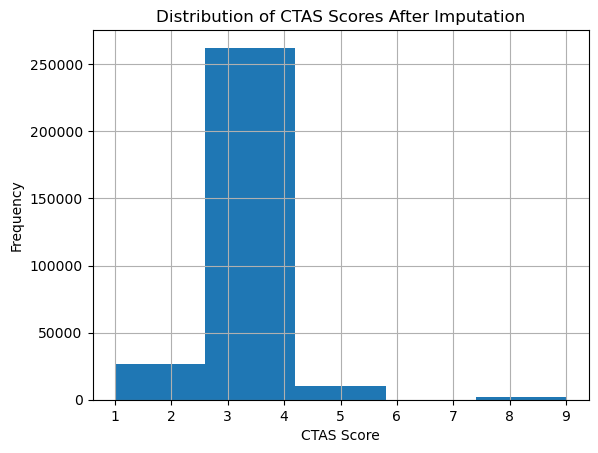

In [18]:
# A significant proportion of 'RLWBS' (25.02%) and 'TLWBS' (6.41%) is in the missing CTAS dataset, this is higher compared
# to their proportions in the entire dataset (0.26% and 10.80% respectively). I will code it “9”.

# Coding missing CTAS values as 9
df_event_log_visits['CTAS'].fillna(9, inplace=True)


# Verifying no missing values
print(f"After imputation, remaining missing values in 'CTAS': {df_event_log_visits['CTAS'].isnull().sum()}")

# the distribution after imputation
df_event_log_visits['CTAS'].hist(bins=5)
plt.title('Distribution of CTAS Scores After Imputation')
plt.xlabel('CTAS Score')
plt.ylabel('Frequency')
plt.show()

In [19]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   SID                      301208 non-null  object 
 1   SEX                      301208 non-null  object 
 2   DOB                      301208 non-null  object 
 3   DOD                      11463 non-null   object 
 4   ED_POSTAL_CODE           301208 non-null  object 
 5   FACILITY_ID              301208 non-null  object 
 6   FACILITY_NAME            301208 non-null  object 
 7   VISIT_ID                 301208 non-null  object 
 8   VISIT_AGE                301208 non-null  float64
 9   CTAS                     301208 non-null  float64
 10  DEPART_DISPOSITION_ID    300778 non-null  object 
 11  DEPART_DISPOSITION_DESC  300778 non-null  object 
 12  Activity                 301208 non-null  object 
 13  TIME_OF_THE_DAY          301208 non-null  object 
 14  Start

## DEPART_DISPOSITION_ID

In [20]:
# Departing disposition is one of the values I will be predicting with the model 
# (TRIAGED LEFT W/O BEING SEEN and REGISTERED LEFT W/O BEING SEEN)
# hence I decided to not deal with the missing values at this moment - however, we only need one of the columns
df_event_log_visits['DEPART_DISPOSITION_DESC'].unique()

array(['DISCHARGED W/O SUPPORT SERV', 'ADMITTED',
       'TRIAGED LEFT W/O BEING SEEN', 'TRANSFER TO OTHER',
       'REGISTERED LEFT W/O BEING SEEN', 'LEFT AGAINST MEDICAL ADVICE',
       'INIT RX LEFT BEFORE COMPLETE', 'ASSESSED LEFT BEFORE TREATMENT',
       'DIED IN FACILITY', 'TRANSFER TO CONTINUING CARE', nan,
       'TRANSFER TO OTHER ACUTE CARE', 'DISCHARGED WITH SUPPORT SERV',
       'TRANSFER TO LONG TERM CARE', 'TRSF TO CORRECTIONAL FACILITY'],
      dtype=object)

In [21]:
df_event_log_visits.drop(['DEPART_DISPOSITION_DESC'], axis=1, inplace=True)

In [22]:
dispositions_counts =  df_event_log_visits['DEPART_DISPOSITION_ID'].value_counts()

# Print the counts
print(dispositions_counts)

DEPART_DISPOSITION_ID
D        245904
TLWBS     32484
ADM       16861
TTO        3027
ITLBC       878
RLWBS       770
AMA         347
TA          152
EXP         127
ALBT        111
DS           47
TC           45
TL           14
TCC          11
Name: count, dtype: int64


# 3) Preprocessing columns
In the next steps I am preprocessing and cleaning data in all columns that will be used by the deep learning model.

## SEX

In [23]:
# preprocessing the SEX column

df_event_log_visits['SEX'].value_counts()

SEX
F    166092
M    135055
U        61
Name: count, dtype: int64

In [24]:
# Encode 'M' as 0 and 'F' as 1 and 'U' as 2
df_event_log_visits['SEX'] = df_event_log_visits['SEX'].map({'M': 0, 'F': 1, 'U': 2})
df_event_log_visits

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours
35406,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Triage,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:22:00+00:00,0.550000
35407,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Providing service,Early Morning to Morning,2022-04-01 00:22:00+00:00,2022-04-01 00:24:00+00:00,0.550000
35408,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Assessment,Early Morning to Morning,2022-04-01 00:24:00+00:00,2022-04-01 00:30:00+00:00,0.550000
35409,STDY147061,1,1959-07-14,NaN,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,D,Patient departed,Early Morning to Morning,2022-04-01 00:30:00+00:00,2022-04-01 00:55:00+00:00,0.550000
213493,STDY321073,0,1999-02-08,NaN,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,D,Triage,Early Morning to Morning,2022-04-01 00:40:00+00:00,2022-04-01 00:40:00+00:00,5.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259174,STDY586460,1,1989-07-22,NaN,A1B 0G5,HSC,Health Sciences Centre - St. Johns,VISIT2377969,33.750000,4.0,TLWBS,Patient departed,Evening to Night,2023-04-30 23:51:00+00:00,2023-05-01 02:30:00+00:00,2.750000
148393,STDY258323,1,1961-03-12,NaN,A1E 3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,D,Triage,Evening to Night,2023-04-30 23:45:00+00:00,2023-04-30 23:45:00+00:00,8.233333
148394,STDY258323,1,1961-03-12,NaN,A1E 3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,D,Providing service,Evening to Night,2023-04-30 23:45:00+00:00,2023-04-30 23:52:00+00:00,8.233333
148395,STDY258323,1,1961-03-12,NaN,A1E 3T9,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2377970,62.083333,3.0,D,Assessment,Evening to Night,2023-04-30 23:52:00+00:00,2023-05-01 07:50:00+00:00,8.233333


## DATE OF BIRTH

In [25]:
# preprocessing the DOB column

# converting the 'DOB' column to datetime
df_event_log_visits['DOB'] = pd.to_datetime(df_event_log_visits['DOB'])


## 3.1) Creating new features based on the old features
Here, I am creating new features based on the available features in the dataset.

## DATE OF DEATH and IS_DECEASED

In [26]:
# Preprocessing the DOD column by creating a binary indicator from DOD
df_event_log_visits['Is_Deceased'] = df_event_log_visits['DOD'].notnull().astype(int)

df_event_log_visits['DOD'] = pd.to_datetime(df_event_log_visits['DOD'], errors='coerce')

df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   SID                    301208 non-null  object        
 1   SEX                    301208 non-null  int64         
 2   DOB                    301208 non-null  datetime64[ns]
 3   DOD                    11463 non-null   datetime64[ns]
 4   ED_POSTAL_CODE         301208 non-null  object        
 5   FACILITY_ID            301208 non-null  object        
 6   FACILITY_NAME          301208 non-null  object        
 7   VISIT_ID               301208 non-null  object        
 8   VISIT_AGE              301208 non-null  float64       
 9   CTAS                   301208 non-null  float64       
 10  DEPART_DISPOSITION_ID  300778 non-null  object        
 11  Activity               301208 non-null  object        
 12  TIME_OF_THE_DAY        301208 non-null  objec

In [27]:

# inspecting the unique values in 'DEPART_DISPOSITION_ID' when 'Is_Deceased' is True
deceased_dispositions = df_event_log_visits[df_event_log_visits['Is_Deceased'] == 1]['DEPART_DISPOSITION_ID'].value_counts()

# A cross-tabulation to see the relationship more clearly
crosstab = pd.crosstab(df_event_log_visits['Is_Deceased'], df_event_log_visits['DEPART_DISPOSITION_ID'])

print("Distribution of departure dispositions for deceased cases:")
print(deceased_dispositions)

print("\nCross-tabulation of 'Is_Deceased' and 'DEPART_DISPOSITION_ID':")
print(crosstab)


Distribution of departure dispositions for deceased cases:
DEPART_DISPOSITION_ID
D        7137
ADM      3171
TLWBS     504
TTO       348
EXP       127
ITLBC      49
AMA        42
TA         14
RLWBS       6
Name: count, dtype: int64

Cross-tabulation of 'Is_Deceased' and 'DEPART_DISPOSITION_ID':
DEPART_DISPOSITION_ID    ADM  ALBT  AMA       D  DS  EXP  ITLBC  RLWBS   TA  \
Is_Deceased                                                                   
0                      13690   111  305  238767  47    0    829    764  138   
1                       3171     0   42    7137   0  127     49      6   14   

DEPART_DISPOSITION_ID  TC  TCC  TL  TLWBS   TTO  
Is_Deceased                                      
0                      45   11  14  31980  2679  
1                       0    0   0    504   348  


In [28]:

df_event_log_visits['DOD'] = pd.to_datetime(df_event_log_visits['DOD'], errors='coerce').dt.tz_localize(None).dt.tz_localize('UTC')

# comparisons
df_event_log_visits['Died_Before_Visit'] = (df_event_log_visits['DOD'] < df_event_log_visits['Start_Time']).astype(int)
df_event_log_visits['Died_During_Visit'] = ((df_event_log_visits['DOD'] >= df_event_log_visits['Start_Time']) & 
                                            (df_event_log_visits['DOD'] <= df_event_log_visits['Activity_End_Time'])).astype(int)
df_event_log_visits['Died_After_Visit'] = (df_event_log_visits['DOD'] > df_event_log_visits['Activity_End_Time']).astype(int)


In [29]:
# Filtering for rows where 'Is_Deceased' is 1 and display the first few rows
deceased_visits = df_event_log_visits[df_event_log_visits['Is_Deceased'] == 1]
deceased_visits.head()


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Activity,TIME_OF_THE_DAY,Start_Time,Activity_End_Time,Duration_hours,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit
184209,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C 2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,D,Triage,Early Morning to Morning,2022-04-01 02:50:00+00:00,2022-04-01 02:50:00+00:00,4.0,1,0,0,1
184210,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C 2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,D,Providing service,Early Morning to Morning,2022-04-01 02:50:00+00:00,2022-04-01 02:59:00+00:00,4.0,1,0,0,1
184211,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C 2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,D,Assessment,Early Morning to Morning,2022-04-01 02:59:00+00:00,2022-04-01 06:30:00+00:00,4.0,1,0,0,1
184212,STDY293268,0,1945-10-26,2023-04-15 00:00:00+00:00,A1C 2B5,SCM,St. Clares Mercy Hospital - St. Johns,VISIT2208415,76.500000,4.0,D,Patient departed,Early Morning to Morning,2022-04-01 06:30:00+00:00,2022-04-01 06:50:00+00:00,4.0,1,0,0,1
222707,STDY327615,0,1963-08-25,2022-04-04 00:00:00+00:00,A1B 5C4,HSC,Health Sciences Centre - St. Johns,VISIT2208489,58.666667,3.0,D,Triage,Late Morning to Late Afternoon,2022-04-01 09:30:00+00:00,2022-04-01 09:30:00+00:00,8.0,1,0,0,1


In [30]:
# checking counts:
died_before_visit_count = df_event_log_visits[df_event_log_visits['Died_Before_Visit'] == 1].shape[0]
print("Number of cases where death occurred before the visit:", died_before_visit_count)

died_during_visit_count = df_event_log_visits[df_event_log_visits['Died_During_Visit'] == 1].shape[0]
print("Number of cases where death occurred during the visit:", died_during_visit_count)

died_after_visit_count = df_event_log_visits[df_event_log_visits['Died_After_Visit'] == 1].shape[0]
print("Number of cases where death occurred after the visit:", died_after_visit_count)


Number of cases where death occurred before the visit: 185
Number of cases where death occurred during the visit: 206
Number of cases where death occurred after the visit: 11072


## AREA_TYPE

In [31]:
# identifying rural or urban area based on the postal code according to
# https://www.canadapost-postescanada.ca/cpc/en/support/articles/addressing-guidelines/postal-codes.page

# Function to determine if a postal code is urban or rural
def urban_rural_classifier(postal_code):
    # Check the second character of the postal code
    if postal_code[1] == '0':
        return 'rural'
    else:
        return 'urban'

# Apply the function to classify each postal code
df_event_log_visits['Area_Type'] = df_event_log_visits['ED_POSTAL_CODE'].apply(urban_rural_classifier)

# Verify by displaying the DataFrame
print(df_event_log_visits[['ED_POSTAL_CODE', 'Area_Type']].head())

       ED_POSTAL_CODE Area_Type
35406         A0A 2B0     rural
35407         A0A 2B0     rural
35408         A0A 2B0     rural
35409         A0A 2B0     rural
213493        A1B 1Z6     urban


In [32]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301208 entries, 35406 to 148396
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301208 non-null  object             
 1   SEX                    301208 non-null  int64              
 2   DOB                    301208 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE         301208 non-null  object             
 5   FACILITY_ID            301208 non-null  object             
 6   FACILITY_NAME          301208 non-null  object             
 7   VISIT_ID               301208 non-null  object             
 8   VISIT_AGE              301208 non-null  float64            
 9   CTAS                   301208 non-null  float64            
 10  DEPART_DISPOSITION_ID  300778 non-null  object             
 11  Activity               301208 non-null  

## COORDINATES

In [33]:
# adding latutide and longitude table from geonames
file_path = 'CA_full.txt'
postal_codes = pd.read_csv(file_path, delimiter='\t', names=[
    'Country', 'Postal_Code', 'Place_Name', 'Province', 'Province_Code',
    'Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Latitude', 'Longitude', 'Extra'
], skiprows=1)  # skiprows=1 to skip the example header row you pasted

# Dropping the unnecessary columns
postal_codes.drop(columns=['Unnamed5', 'Unnamed6', 'Unnamed7', 'Unnamed8', 'Extra'], inplace=True)

# Displaying the dataframe to ensure it loaded correctly
print(postal_codes.head())


  Country Postal_Code    Place_Name Province Province_Code  Latitude  \
0      CA     T0A 0A1   Saddle Lake  Alberta            AB   54.0029   
1      CA     T0A 0A2  Cherry Grove  Alberta            AB   54.3603   
2      CA     T0A 0A3       Glendon  Alberta            AB   54.3455   
3      CA     T0A 0A4     Lindbergh  Alberta            AB   54.3455   
4      CA     T0A 0A5       St Lina  Alberta            AB   54.3455   

   Longitude  
0  -111.7000  
1  -110.0863  
2  -111.6157  
3  -111.6157  
4  -111.6157  


In [34]:
# checking for duplicates 

print(postal_codes['Postal_Code'].duplicated().sum())
postal_codes = postal_codes.drop_duplicates(subset=['Postal_Code'], keep='first')


891


In [35]:
# Merging the dataframes
df_event_log_visits = df_event_log_visits.merge(postal_codes, left_on='ED_POSTAL_CODE', right_on='Postal_Code', how='left')

# Checking for missing latitude and longitude after the merge
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     4692
Longitude    4692
dtype: int64


In [36]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301208 entries, 0 to 301207
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301208 non-null  object             
 1   SEX                    301208 non-null  int64              
 2   DOB                    301208 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE         301208 non-null  object             
 5   FACILITY_ID            301208 non-null  object             
 6   FACILITY_NAME          301208 non-null  object             
 7   VISIT_ID               301208 non-null  object             
 8   VISIT_AGE              301208 non-null  float64            
 9   CTAS                   301208 non-null  float64            
 10  DEPART_DISPOSITION_ID  300778 non-null  object             
 11  Activity               301208 non-null 

In [37]:
# some of the postal codes can not be found on geonames as they are - the closest coordinates can be found by using
# only the first three digits
postal_codes['First_3_Digits'] = postal_codes['Postal_Code'].str[:3]


In [38]:
# rows where 'Latitude' or 'Longitude' is missing 
df_event_log_visits_missing_lat = df_event_log_visits[df_event_log_visits['Latitude'].isnull() | df_event_log_visits['Longitude'].isnull()]

# creating nnew column
df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits_missing_lat

C:\Users\ksteflova\AppData\Local\Temp\ipykernel_9668\2478119479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits_missing_lat['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Died_After_Visit,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
499,STDY162569,1,1991-06-04,NaT,A1L 5V6,HSC,Health Sciences Centre - St. Johns,VISIT2208684,30.833333,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1L
500,STDY162569,1,1991-06-04,NaT,A1L 5V6,HSC,Health Sciences Centre - St. Johns,VISIT2208684,30.833333,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1L
501,STDY162569,1,1991-06-04,NaT,A1L 5V6,HSC,Health Sciences Centre - St. Johns,VISIT2208684,30.833333,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A1L
563,STDY293437,0,1958-04-04,NaT,A5A 0H3,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2208721,64.000000,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
564,STDY293437,0,1958-04-04,NaT,A5A 0H3,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2208721,64.000000,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300430,STDY167108,1,1994-09-20,NaT,A5A 0K1,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377489,28.583333,3.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
301094,STDY348394,0,2017-05-29,NaT,A5A 0H8,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377906,5.916667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
301095,STDY348394,0,2017-05-29,NaT,A5A 0H8,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377906,5.916667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A
301096,STDY348394,0,2017-05-29,NaT,A5A 0H8,GBC,Dr. G.B. Cross Memorial Hospital - Clarenville,VISIT2377906,5.916667,4.0,...,0,urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5A


In [39]:

# Merging the missing latitude/longitude DataFrame with postal_codes to get the corresponding latitude/longitude
df_merged = df_event_log_visits_missing_lat.merge(postal_codes, on='First_3_Digits', how='left', suffixes=('', '_pc'))

# Displaying the merged DataFrame
print(df_merged.head())


          SID  SEX        DOB DOD ED_POSTAL_CODE FACILITY_ID  \
0  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
1  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
2  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
3  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   
4  STDY162569    1 1991-06-04 NaT        A1L 5V6         HSC   

                        FACILITY_NAME      VISIT_ID  VISIT_AGE  CTAS  ...  \
0  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
1  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
2  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
3  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   
4  Health Sciences Centre - St. Johns  VISIT2208684  30.833333   4.0  ...   

  Latitude Longitude First_3_Digits Country_pc Postal_Code_pc  Place_Name_pc  \
0      NaN       NaN            A1L         CA        A1L 0A2       Para

In [40]:
# adding new column to the original dataset to merge on
df_event_log_visits['First_3_Digits'] = df_event_log_visits['ED_POSTAL_CODE'].str[:3]
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Died_After_Visit,Area_Type,Country,Postal_Code,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,0,rural,CA,A0A 2B0,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,0,urban,CA,A1B 1Z6,St. John's,Newfoundland and Labrador,NL,47.5679,-52.7422,A1B


In [41]:
# Find the rows in the main dataset where latitude and longitude are missing
missing_indices = df_event_log_visits[df_event_log_visits['Latitude'].isna() & df_event_log_visits['Longitude'].isna()].index

# Update the main dataset with the latitude and longitude from the merged DataFrame
df_event_log_visits.loc[missing_indices, 'Latitude'] = df_merged['Latitude_pc']
df_event_log_visits.loc[missing_indices, 'Longitude'] = df_merged['Longitude_pc']

# Check if the missing values are updated
print(df_event_log_visits.loc[missing_indices, ['First_3_Digits', 'Latitude', 'Longitude']])


       First_3_Digits  Latitude  Longitude
499               A1L   47.5410   -52.8749
500               A1L   47.5421   -52.8741
501               A1L   47.5426   -52.8727
563               A5A   47.5474   -52.9002
564               A5A   47.5477   -52.9048
...               ...       ...        ...
300430            A5A   47.5947   -52.7043
301094            A5A   47.6012   -52.7123
301095            A5A   47.6039   -52.7151
301096            A5A   47.6039   -52.7167
301097            A5A   47.6019   -52.7379

[4692 rows x 3 columns]


In [42]:
# an overview of all missing values in the DataFrame
print(df_event_log_visits.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301208 entries, 0 to 301207
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301208 non-null  object             
 1   SEX                    301208 non-null  int64              
 2   DOB                    301208 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE         301208 non-null  object             
 5   FACILITY_ID            301208 non-null  object             
 6   FACILITY_NAME          301208 non-null  object             
 7   VISIT_ID               301208 non-null  object             
 8   VISIT_AGE              301208 non-null  float64            
 9   CTAS                   301208 non-null  float64            
 10  DEPART_DISPOSITION_ID  300778 non-null  object             
 11  Activity               301208 non-null 

In [43]:
# Dropping rows where either Latitude or Longitude is missing (3 rows)
df_event_log_visits = df_event_log_visits.dropna(subset=['Latitude', 'Longitude'])

# Verifying the result
print(df_event_log_visits[['Latitude', 'Longitude']].isnull().sum())


Latitude     0
Longitude    0
dtype: int64


## DISTANCE_TO_HOSPITAL

In [44]:
from geopy.distance import geodesic

# Hospital coordinates dictionary (includes all hospitals)
hospital_coords = {
    'Health Sciences Centre - St. Johns': (47.57173844188426, -52.7428752808959),
    'St. Clares Mercy Hospital - St. Johns': (47.55783035337661, -52.72164112844875),
    'Dr. G.B. Cross Memorial Hospital - Clarenville': (48.165186482963676, -53.98449946306605),
    'Carbonear General Hospital - Carbonear': (47.725414948091, -53.226560474732224),
    'Burin Peninsula Health care Centre - Burin': (47.10500591911938, -55.19465935942642),  
}

# Calculating the distance between a case and a hospital
def calculate_distance(row, hospital_name):
    case_coords = (row['Latitude'], row['Longitude'])
    hospital_coords_tuple = hospital_coords.get(hospital_name, None)  
    if hospital_coords_tuple is None:
        return float('nan')  # Return NaN if the hospital isn't in the dictionary
    return geodesic(case_coords, hospital_coords_tuple).km  # Distance in kilometers

# Applying the function to calculate distances for all hospitals
df_event_log_visits['Distance_to_Hospital'] = df_event_log_visits.apply(
    lambda row: calculate_distance(row, row['FACILITY_NAME']),
    axis=1
)

# Displaying DataFrame with the calculated distances
print(df_event_log_visits[['VISIT_ID', 'FACILITY_NAME', 'Distance_to_Hospital']].head())


       VISIT_ID                           FACILITY_NAME  Distance_to_Hospital
0  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
1  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
2  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
3  VISIT2208402  Carbonear General Hospital - Carbonear              22.23370
4  VISIT2208404      Health Sciences Centre - St. Johns               0.42978


## IS_NL_HOLIDAY

In [45]:
# List of Newfoundland and Labrador holidays in "MM-DD" format
nl_holidays = {
    "01-01",  # New Year's Day
    "03-17",  # St. Patrick's Day
    "04-23",  # St. George's Day
    "06-24",  # Discovery Day
    "07-01",  # Canada Day
    "09-02",  # Labour Day
    "10-14",  # Thanksgiving
    "11-11",  # Remembrance Day
    "12-25",  # Christmas Day
    "12-26"   # Boxing Day
}

# checking if a given date matches a holiday
def is_nl_holiday(date):
    # Extracting month and day from the date
    month_day = date.strftime("%m-%d")
    return month_day in nl_holidays


In [46]:
# Converting 'Start_Time' to datetime 
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Applying the function to create a new column
df_event_log_visits['Is_NL_Holiday'] = df_event_log_visits['Start_Time'].apply(is_nl_holiday)

# Displaying results
print(df_event_log_visits[['Start_Time', 'Is_NL_Holiday']].head())



                 Start_Time  Is_NL_Holiday
0 2022-04-01 00:22:00+00:00          False
1 2022-04-01 00:22:00+00:00          False
2 2022-04-01 00:24:00+00:00          False
3 2022-04-01 00:30:00+00:00          False
4 2022-04-01 00:40:00+00:00          False


## DAY_OF_WEEK and IS_WEEKEND

In [47]:
# Getting the day of the week (0 = Monday, 6 = Sunday)
df_event_log_visits['Day_of_Week'] = pd.to_datetime(df_event_log_visits['Start_Time']).dt.dayofweek
df_event_log_visits['Is_Weekend'] = df_event_log_visits['Day_of_Week'].isin([5, 6])


In [48]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Place_Name,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Cupids,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,St. John's,Newfoundland and Labrador,NL,47.5679,-52.7422,A1B,0.42978,False,4,False


## VISIT_SEASON

In [49]:
# Defining season ranges
seasons = {
    "Winter": (1, 2, 12),
    "Spring": (3, 4, 5),
    "Summer": (6, 7, 8),
    "Fall": (9, 10, 11)
}

# Function to get the season
def get_season(month):
    for season, months in seasons.items():
        if month in months:
            return season
    return None

df_event_log_visits['Visit_Season'] = df_event_log_visits['Start_Time'].apply(
    lambda x: get_season(pd.to_datetime(x).month)
)


In [50]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Province,Province_Code,Latitude,Longitude,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season
0,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
1,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
2,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
3,STDY147061,1,1959-07-14,NaT,A0A 2B0,CGH,Carbonear General Hospital - Carbonear,VISIT2208402,62.750000,3.0,...,Newfoundland and Labrador,NL,47.5267,-53.2597,A0A,22.23370,False,4,False,Spring
4,STDY321073,0,1999-02-08,NaT,A1B 1Z6,HSC,Health Sciences Centre - St. Johns,VISIT2208404,23.166667,4.0,...,Newfoundland and Labrador,NL,47.5679,-52.7422,A1B,0.42978,False,4,False,Spring


## VISIT_FREQUENCY

In [51]:
# Ensuring 'Start_Time' is in datetime format
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Sorting the data
df_event_log_visits.sort_values(by=['SID', 'Start_Time'], inplace=True)

# Identifying the latest visit for each SID
df_event_log_visits['Latest_Visit'] = df_event_log_visits.groupby('SID')['Start_Time'].transform('max')

# Marking rows that correspond to the latest visit
df_event_log_visits['Is_Latest_Visit'] = df_event_log_visits['Start_Time'] == df_event_log_visits['Latest_Visit']

# Counting all unique visits per SID
visit_counts = df_event_log_visits.groupby('SID')['VISIT_ID'].nunique()

# Subtracting 1 from the counts to exclude the current visit (where there are previous visits)
visit_counts = visit_counts - 1

# Ensuring that no negative counts are present (in cases with only one visit)
visit_counts = visit_counts.clip(lower=0)

# Mapping the adjusted visit counts back to the original DataFrame
df_event_log_visits['Visit_Frequency'] = df_event_log_visits['SID'].map(visit_counts)

# Display the result
print(df_event_log_visits[['SID', 'VISIT_ID', 'Visit_Frequency']].head())


               SID      VISIT_ID  Visit_Frequency
264956  STDY111126  VISIT2354278                0
264957  STDY111126  VISIT2354278                0
264958  STDY111126  VISIT2354278                0
49036   STDY111131  VISIT2233914                1
49037   STDY111131  VISIT2233914                1


In [52]:
df_event_log_visits.drop(columns=['Latest_Visit', 'Is_Latest_Visit'], inplace=True)


In [53]:
df_event_log_visits.describe()

,SEX,DOB,VISIT_AGE,CTAS,Duration_hours,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Latitude,Longitude,Distance_to_Hospital,Day_of_Week,Visit_Frequency
count,301205.000000,301205,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000
mean,0.551830,1973-07-19 19:45:54.324795424,49.204183,3.471509,16.950479,0.038057,0.000614,0.000684,0.036759,47.702874,-53.776359,63.417257,2.882844,1.563942
min,0.000000,1917-04-13 00:00:00,0.000000,1.000000,0.016667,0.000000,0.000000,0.000000,0.000000,42.092300,-135.127200,0.046097,0.000000,0.000000
25%,0.000000,1955-12-30 00:00:00,31.583333,3.000000,2.300000,0.000000,0.000000,0.000000,0.000000,47.517600,-53.495500,2.921460,1.000000,0.000000
50%,1.000000,1972-07-17 00:00:00,50.250000,3.000000,4.166667,0.000000,0.000000,0.000000,0.000000,47.563000,-52.901200,8.465450,3.000000,1.000000
75%,1.000000,1991-03-02 00:00:00,66.750000,4.000000,6.916667,0.000000,0.000000,0.000000,0.000000,47.710000,-52.752100,21.100593,5.000000,2.000000
max,2.000000,2023-03-27 00:00:00,106.000000,9.000000,4829.850000,1.000000,1.000000,1.000000,1.000000,74.698100,-52.668600,5194.282949,6.000000,83.000000
std,0.497714,NaN,21.292239,0.846985,83.564729,0.191335,0.024775,0.026143,0.188170,0.839557,4.637592,337.354049,1.998213,4.346782


In [54]:
# 'TLWBS' and 'RLWBS' codes indicate left without being seen
lwbs_codes = ['TLWBS', 'RLWBS']
df_event_log_visits['Is_LWBS'] = df_event_log_visits['DEPART_DISPOSITION_ID'].isin(lwbs_codes).astype(int)



In [55]:

df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])

# Sorting the DataFrame by 'SID' and 'Start_Time'
df_event_log_visits.sort_values(by=['SID', 'Start_Time'], inplace=True)

# Identifying the last visit for each SID
df_event_log_visits['Latest_Visit'] = df_event_log_visits.groupby('SID')['Start_Time'].transform('max')

# Excluding the latest visit from counting
condition = df_event_log_visits['Start_Time'] < df_event_log_visits['Latest_Visit']
df_prior_visits = df_event_log_visits[condition]

# Summing up LWBS occurrences per visit, excluding the latest visit
lwbs_per_visit = df_prior_visits.groupby(['SID', 'VISIT_ID'])['Is_LWBS'].max().groupby('SID').cumsum().reset_index()

# Renaming the column in lwbs_per_visit before merging
lwbs_per_visit.rename(columns={'Is_LWBS': 'Prior_LWBS'}, inplace=True)

# Merging this cumulative count back to the original DataFrame on both SID and VISIT_ID
df_event_log_visits = df_event_log_visits.merge(lwbs_per_visit, on=['SID', 'VISIT_ID'], how='left', suffixes=('', '_cumulative'))

# Replacing NaN with 0 for visits without any prior LWBS events
df_event_log_visits['Prior_LWBS'].fillna(0, inplace=True)

# Dropping the temporary column if no longer needed
df_event_log_visits.drop(columns='Latest_Visit', inplace=True)

# Display the DataFrame to verify results
print(df_event_log_visits[['SID', 'VISIT_ID', 'Prior_LWBS']].head())


          SID      VISIT_ID  Prior_LWBS
0  STDY111126  VISIT2354278         1.0
1  STDY111126  VISIT2354278         1.0
2  STDY111126  VISIT2354278         1.0
3  STDY111131  VISIT2233914         0.0
4  STDY111131  VISIT2233914         0.0


In [56]:
# Filtering rows for SID 'STDY111131' and displaying specific columns
filtered_rows = df_event_log_visits[df_event_log_visits['SID'] == 'STDY111131']
print(filtered_rows[['SID', 'VISIT_ID', 'Prior_LWBS', 'DEPART_DISPOSITION_ID']])


           SID      VISIT_ID  Prior_LWBS DEPART_DISPOSITION_ID
3   STDY111131  VISIT2233914         0.0                     D
4   STDY111131  VISIT2233914         0.0                     D
5   STDY111131  VISIT2233914         0.0                     D
6   STDY111131  VISIT2233914         0.0                     D
7   STDY111131  VISIT2234433         0.0                     D
8   STDY111131  VISIT2234433         0.0                     D
9   STDY111131  VISIT2234433         0.0                     D
10  STDY111131  VISIT2234433         0.0                     D


In [57]:
df_event_log_visits.columns

Index(['SID', 'SEX', 'DOB', 'DOD', 'ED_POSTAL_CODE', 'FACILITY_ID',
       'FACILITY_NAME', 'VISIT_ID', 'VISIT_AGE', 'CTAS',
       'DEPART_DISPOSITION_ID', 'Activity', 'TIME_OF_THE_DAY', 'Start_Time',
       'Activity_End_Time', 'Duration_hours', 'Is_Deceased',
       'Died_Before_Visit', 'Died_During_Visit', 'Died_After_Visit',
       'Area_Type', 'Country', 'Postal_Code', 'Place_Name', 'Province',
       'Province_Code', 'Latitude', 'Longitude', 'First_3_Digits',
       'Distance_to_Hospital', 'Is_NL_Holiday', 'Day_of_Week', 'Is_Weekend',
       'Visit_Season', 'Visit_Frequency', 'Is_LWBS', 'Prior_LWBS'],
      dtype='object')

In [58]:
df_event_log_visits.describe()

,SEX,DOB,VISIT_AGE,CTAS,Duration_hours,Is_Deceased,Died_Before_Visit,Died_During_Visit,Died_After_Visit,Latitude,Longitude,Distance_to_Hospital,Day_of_Week,Visit_Frequency,Is_LWBS,Prior_LWBS
count,301205.000000,301205,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000,301205.000000
mean,0.551830,1973-07-19 19:45:54.324795424,49.204183,3.471509,16.950479,0.038057,0.000614,0.000684,0.036759,47.702874,-53.776359,63.417257,2.882844,1.563942,0.110403,0.272725
min,0.000000,1917-04-13 00:00:00,0.000000,1.000000,0.016667,0.000000,0.000000,0.000000,0.000000,42.092300,-135.127200,0.046097,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1955-12-30 00:00:00,31.583333,3.000000,2.300000,0.000000,0.000000,0.000000,0.000000,47.517600,-53.495500,2.921460,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1972-07-17 00:00:00,50.250000,3.000000,4.166667,0.000000,0.000000,0.000000,0.000000,47.563000,-52.901200,8.465450,3.000000,1.000000,0.000000,0.000000
75%,1.000000,1991-03-02 00:00:00,66.750000,4.000000,6.916667,0.000000,0.000000,0.000000,0.000000,47.710000,-52.752100,21.100593,5.000000,2.000000,0.000000,0.000000
max,2.000000,2023-03-27 00:00:00,106.000000,9.000000,4829.850000,1.000000,1.000000,1.000000,1.000000,74.698100,-52.668600,5194.282949,6.000000,83.000000,1.000000,35.000000
std,0.497714,NaN,21.292239,0.846985,83.564729,0.191335,0.024775,0.026143,0.188170,0.839557,4.637592,337.354049,1.998213,4.346782,0.313392,1.079779


## ED_BUSINESS_HOURLY

In [59]:

# Groupping by hour to get the number of patient arrivals in each hour
arrival_counts = df_event_log_visits.groupby(df_event_log_visits['Start_Time'].dt.floor('H')).size()

# Mappinng the hourly counts back to the original DataFrame
df_event_log_visits['ED_Business_Hourly'] = df_event_log_visits['Start_Time'].dt.floor('H').map(arrival_counts)


print(df_event_log_visits[['Start_Time', 'ED_Business_Hourly']].head())


                 Start_Time  ED_Business_Hourly
0 2023-03-04 23:08:00+00:00                  17
1 2023-03-04 23:08:00+00:00                  17
2 2023-03-04 23:09:00+00:00                  17
3 2022-05-30 08:10:00+00:00                  70
4 2022-05-30 08:10:00+00:00                  70


In [60]:

df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,First_3_Digits,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly
0,STDY111126,1,1997-01-19,NaT,A0B 3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,A0B,55.947701,False,5,True,Spring,0,1,1.0,17
1,STDY111126,1,1997-01-19,NaT,A0B 3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,A0B,55.947701,False,5,True,Spring,0,1,1.0,17
2,STDY111126,1,1997-01-19,NaT,A0B 3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,A0B,55.947701,False,5,True,Spring,0,1,1.0,17
3,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2233914,22.000000,4.0,...,A0E,243.167901,False,0,False,Spring,1,0,0.0,70
4,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2233914,22.000000,4.0,...,A0E,243.167901,False,0,False,Spring,1,0,0.0,70


## IMAGING_DONE and LABS_DONE

In [61]:
# Loading the Excel file for imaging data
imaging_data = pd.read_excel("October2023_Data\INC10447_ED_VISIT_IMAGES_20230929.xlsx")

# Loading the CSV file for lab tests data
labs_data = pd.read_csv("October2023_Data\INC10447_ED_VISIT_LABS_20230929.csv")

# Displaying the first few rows to ensure correct data loading
print("Imaging Data:")
print(imaging_data.head())
print("Labs Data:")
print(labs_data.head())

Imaging Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
0  STDY111111  VISIT2102120      2021-07-12          2021-07-12   
1  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
2  STDY111113  VISIT1942974      2020-05-26          2020-05-27   
3  STDY111115  VISIT1996593      2020-10-08          2020-10-08   
4  STDY111116  VISIT1424440      2017-03-19          2017-03-19   

     IMAGE_TEST_NAME  
0  CHEST DUAL ENERGY  
1          HAND LEFT  
2      SCAPHOID LEFT  
3          FOOT LEFT  
4   CHEST PA+LATERAL  
Labs Data:
          SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE    LAB_TEST_NAME
0  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021        ANION GAP
1  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021  BILIRUBIN;TOTAL
2  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021              CBC
3  STDY111111  VISIT2102120     12-JUL-2021       12-JUL-2021         CHLORIDE
4  STDY111111  VISIT2102120     12-JUL-

In [62]:
# Convert the date columns to datetime type
imaging_data['ED_SERVICE_DATE'] = pd.to_datetime(imaging_data['ED_SERVICE_DATE'])
imaging_data['IMAGE_REPORTED_DATE'] = pd.to_datetime(imaging_data['IMAGE_REPORTED_DATE'])
labs_data['ED_SERVICE_DATE'] = pd.to_datetime(labs_data['ED_SERVICE_DATE'])
labs_data['LAB_REPORTED_DATE'] = pd.to_datetime(labs_data['LAB_REPORTED_DATE'])

# Define the date range
start_date = '2022-04-01'
end_date = '2023-04-30'

# Filter the Imaging Data
filtered_imaging_data = imaging_data[
    (imaging_data['ED_SERVICE_DATE'] >= start_date) & 
    (imaging_data['ED_SERVICE_DATE'] <= end_date)
]

# Filter the Labs Data
filtered_labs_data = labs_data[
    (labs_data['ED_SERVICE_DATE'] >= start_date) & 
    (labs_data['ED_SERVICE_DATE'] <= end_date)
]

# Check the filtered data
print("Filtered Imaging Data:", filtered_imaging_data.head())
print("Filtered Labs Data:", filtered_labs_data.head())


C:\Users\ksteflova\AppData\Local\Temp\ipykernel_9668\2150560135.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  labs_data['ED_SERVICE_DATE'] = pd.to_datetime(labs_data['ED_SERVICE_DATE'])
C:\Users\ksteflova\AppData\Local\Temp\ipykernel_9668\2150560135.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  labs_data['LAB_REPORTED_DATE'] = pd.to_datetime(labs_data['LAB_REPORTED_DATE'])


Filtered Imaging Data:            SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
31  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
32  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
35  STDY111135  VISIT2323052      2022-12-17          2022-12-17   
36  STDY111135  VISIT2361850      2023-03-23          2023-03-23   
56  STDY111151  VISIT2342133      2023-02-01          2023-02-01   

                  IMAGE_TEST_NAME  
31                   SPINE LUMBAR  
32                 SPINE THORACIC  
35  HEAD COMPLEX WITHOUT CONTRAST  
36              CHEST DUAL ENERGY  
56      VEIN LOWER EXTREMITY LEFT  
Filtered Labs Data:             SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE  \
284  STDY111131  VISIT2234433      2022-05-31        2022-05-31   
324  STDY111135  VISIT2323052      2022-12-17        2022-12-17   
325  STDY111135  VISIT2323052      2022-12-17        2022-12-17   
326  STDY111135  VISIT2323052      2022-12-17        2022-12-17 

In [63]:
# Aggregate Imaging Data by visit
imaging_summary = filtered_imaging_data.groupby(['SID', 'ED_VISIT_ID'])['IMAGE_TEST_NAME'].agg([
    ('Imaging_Tests', lambda x: ', '.join(x.unique())),  # Concatenate unique test names
    ('Num_Imaging_Tests', 'nunique')                     # Count unique tests
]).reset_index()

# Aggregate Labs Data by visit
labs_summary = filtered_labs_data.groupby(['SID', 'ED_VISIT_ID'])['LAB_TEST_NAME'].agg([
    ('Lab_Tests', lambda x: ', '.join(x.unique())),       # Concatenate unique lab names
    ('Num_Lab_Tests', 'nunique')                          # Count unique labs
]).reset_index()

# Merge the summaries with the main dataset
df_event_log_visits = df_event_log_visits.merge(imaging_summary, how='left', left_on=['SID', 'VISIT_ID'], right_on=['SID', 'ED_VISIT_ID'])
df_event_log_visits = df_event_log_visits.merge(labs_summary, how='left', left_on=['SID', 'VISIT_ID'], right_on=['SID', 'ED_VISIT_ID'])

# Clean up the merged DataFrame
df_event_log_visits.drop(columns=['ED_VISIT_ID_x', 'ED_VISIT_ID_y'], inplace=True)

# Replace NaNs in new columns with appropriate defaults
df_event_log_visits[['Imaging_Tests', 'Lab_Tests']].fillna('None', inplace=True)
df_event_log_visits[['Num_Imaging_Tests', 'Num_Lab_Tests']].fillna(0, inplace=True)

# Display to verify
print(df_event_log_visits.head())


          SID  SEX        DOB DOD ED_POSTAL_CODE FACILITY_ID  \
0  STDY111126    1 1997-01-19 NaT        A0B 3K0         HSC   
1  STDY111126    1 1997-01-19 NaT        A0B 3K0         HSC   
2  STDY111126    1 1997-01-19 NaT        A0B 3K0         HSC   
3  STDY111131    1 2000-05-02 NaT        A0E 1P0         HSC   
4  STDY111131    1 2000-05-02 NaT        A0E 1P0         HSC   

                        FACILITY_NAME      VISIT_ID  VISIT_AGE  CTAS  ...  \
0  Health Sciences Centre - St. Johns  VISIT2354278  26.166667   3.0  ...   
1  Health Sciences Centre - St. Johns  VISIT2354278  26.166667   3.0  ...   
2  Health Sciences Centre - St. Johns  VISIT2354278  26.166667   3.0  ...   
3  Health Sciences Centre - St. Johns  VISIT2233914  22.000000   4.0  ...   
4  Health Sciences Centre - St. Johns  VISIT2233914  22.000000   4.0  ...   

  Is_Weekend Visit_Season Visit_Frequency Is_LWBS Prior_LWBS  \
0       True       Spring               0       1        1.0   
1       True       Sprin

C:\Users\ksteflova\AppData\Local\Temp\ipykernel_9668\3929436199.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits[['Imaging_Tests', 'Lab_Tests']].fillna('None', inplace=True)
C:\Users\ksteflova\AppData\Local\Temp\ipykernel_9668\3929436199.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_event_log_visits[['Num_Imaging_Tests', 'Num_Lab_Tests']].fillna(0, inplace=True)


In [64]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   SID                    301205 non-null  object             
 1   SEX                    301205 non-null  int64              
 2   DOB                    301205 non-null  datetime64[ns]     
 3   DOD                    11463 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE         301205 non-null  object             
 5   FACILITY_ID            301205 non-null  object             
 6   FACILITY_NAME          301205 non-null  object             
 7   VISIT_ID               301205 non-null  object             
 8   VISIT_AGE              301205 non-null  float64            
 9   CTAS                   301205 non-null  float64            
 10  DEPART_DISPOSITION_ID  300775 non-null  object             
 11  Activity               301205 non-null 

In [65]:
# Check in the Imaging Data
imaging_presence = filtered_imaging_data[filtered_imaging_data['ED_VISIT_ID'] == 'VISIT2354278']

# Check in the Labs Data
labs_presence = filtered_labs_data[filtered_labs_data['ED_VISIT_ID'] == 'VISIT2354278']

# Print the results
print("Imaging Data:")
print(imaging_presence)
print("\nLabs Data:")
print(labs_presence)




Imaging Data:
Empty DataFrame
Columns: [SID, ED_VISIT_ID, ED_SERVICE_DATE, IMAGE_REPORTED_DATE, IMAGE_TEST_NAME]
Index: []

Labs Data:
Empty DataFrame
Columns: [SID, ED_VISIT_ID, ED_SERVICE_DATE, LAB_REPORTED_DATE, LAB_TEST_NAME]
Index: []


In [66]:
# Check in the Imaging Data
imaging_presence = filtered_imaging_data[filtered_imaging_data['ED_VISIT_ID'] == 'VISIT2234433']

# Check in the Labs Data
labs_presence = filtered_labs_data[filtered_labs_data['ED_VISIT_ID'] == 'VISIT2234433']

# Print the results
print("Imaging Data:")
print(imaging_presence)
print("\nLabs Data:")
print(labs_presence)




Imaging Data:
           SID   ED_VISIT_ID ED_SERVICE_DATE IMAGE_REPORTED_DATE  \
31  STDY111131  VISIT2234433      2022-05-31          2022-05-31   
32  STDY111131  VISIT2234433      2022-05-31          2022-05-31   

   IMAGE_TEST_NAME  
31    SPINE LUMBAR  
32  SPINE THORACIC  

Labs Data:
            SID   ED_VISIT_ID ED_SERVICE_DATE LAB_REPORTED_DATE  \
284  STDY111131  VISIT2234433      2022-05-31        2022-05-31   

        LAB_TEST_NAME  
284  URINALYSIS PANEL  


In [67]:
# Filter the DataFrame for the specific VISIT_ID
filtered_data = df_event_log_visits[df_event_log_visits['VISIT_ID'] == 'VISIT2234433']

# Display the filtered DataFrame
filtered_data


,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Is_Weekend,Visit_Season,Visit_Frequency,Is_LWBS,Prior_LWBS,ED_Business_Hourly,Imaging_Tests,Num_Imaging_Tests,Lab_Tests,Num_Lab_Tests
7,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,False,Spring,1,0,0.0,95,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
8,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,False,Spring,1,0,0.0,95,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
9,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,False,Spring,1,0,0.0,98,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0
10,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2234433,22.0,4.0,...,False,Spring,1,0,0.0,65,"SPINE LUMBAR, SPINE THORACIC",2.0,URINALYSIS PANEL,1.0


In [68]:
# Replace NaN values with 0 in the 'Num_Imaging_Tests' and 'Num_Lab_Tests' columns
df_event_log_visits['Num_Imaging_Tests'].fillna(0, inplace=True)
df_event_log_visits['Num_Lab_Tests'].fillna(0, inplace=True)


In [69]:
# Assuming 'Lab_Tests' and 'Imaging_Tests' are columns with lists of tests as strings
df_event_log_visits['First_Lab_Test'] = df_event_log_visits['Lab_Tests'].str.split(',').str[0]
df_event_log_visits['First_Imaging_Test'] = df_event_log_visits['Imaging_Tests'].str.split(',').str[0]


In [70]:
df_event_log_visits['First_Lab_Test'].unique()

array([nan, 'URINALYSIS PANEL', 'ANION GAP', 'AMYLASE', 'APTT', 'CBC',
       'C.TRAC & N.GON DNA PANEL;URINE', 'GLUCOSE;POINT OF CARE',
       'ALBUMIN', 'PREGNANCY TEST;URINE',
       'FIBRIN D-DIMER (D-DIMER UNITS)', 'THROAT;CULTURE',
       'C REACTIVE PROTEIN;HIGH SENS.', 'ACETAMINOPHEN',
       'OCCUPATIONAL EXP WORKER PANEL', 'CORONAVIRUS; NOVEL 2019',
       'URINE;CULTURE', 'CORONAVIRUS;NOVEL 2019 POC', 'GI TRACT',
       'GASTROINTESTINAL PATHOGEN;PCR', 'DRUGS OF ABUSE STAT SCREEN;UR',
       'EPSTEIN BARR VIRUS Ab PANEL', 'VAGINAL;GRAM STAIN;MICROSCOPIC',
       'VANCOMYCIN TROUGH', 'BLOOD TYPE & Ab SCREEN',
       'GRAM STAIN;MICROSCOPIC', 'RESPIRATORY PATHOGEN;PCR',
       'ALANINE AMINOTRANSFERASE', 'TROPONIN CARDIAC', 'SKIN', 'LACTATE',
       'EYE;CULTURE', 'CREATINE KINASE', 'TSH', 'INR', 'CHLORIDE',
       'CARBAMAZEPINE', 'CARCINOEMBRYONIC Ag',
       'GAS & OXIMETRY PANEL; VENOUS', 'HEPATITIS A VIRUS Ab IgM',
       'GAS PANEL; VENOUS', 'GENITAL;CULTURE',
       'GA

In [71]:
df_event_log_visits['First_Imaging_Test'].nunique()

260

In [72]:
from sklearn.preprocessing import LabelEncoder
# Impute missing values
df_event_log_visits['First_Imaging_Test'].fillna('No Imaging', inplace=True)
df_event_log_visits['First_Lab_Test'].fillna('No Test', inplace=True)

# Initialize the label encoders
label_encoder_imaging = LabelEncoder()
label_encoder_lab = LabelEncoder()

# Fit and transform the columns with label encoding
df_event_log_visits['First_Imaging_Test_Encoded'] = label_encoder_imaging.fit_transform(df_event_log_visits['First_Imaging_Test'])
df_event_log_visits['First_Lab_Test_Encoded'] = label_encoder_lab.fit_transform(df_event_log_visits['First_Lab_Test'])



In [73]:
df_event_log_visits.head()

,SID,SEX,DOB,DOD,ED_POSTAL_CODE,FACILITY_ID,FACILITY_NAME,VISIT_ID,VISIT_AGE,CTAS,...,Prior_LWBS,ED_Business_Hourly,Imaging_Tests,Num_Imaging_Tests,Lab_Tests,Num_Lab_Tests,First_Lab_Test,First_Imaging_Test,First_Imaging_Test_Encoded,First_Lab_Test_Encoded
0,STDY111126,1,1997-01-19,NaT,A0B 3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,1.0,17,NaN,0.0,NaN,0.0,No Test,No Imaging,166,85
1,STDY111126,1,1997-01-19,NaT,A0B 3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,1.0,17,NaN,0.0,NaN,0.0,No Test,No Imaging,166,85
2,STDY111126,1,1997-01-19,NaT,A0B 3K0,HSC,Health Sciences Centre - St. Johns,VISIT2354278,26.166667,3.0,...,1.0,17,NaN,0.0,NaN,0.0,No Test,No Imaging,166,85
3,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2233914,22.000000,4.0,...,0.0,70,NaN,0.0,NaN,0.0,No Test,No Imaging,166,85
4,STDY111131,1,2000-05-02,NaT,A0E 1P0,HSC,Health Sciences Centre - St. Johns,VISIT2233914,22.000000,4.0,...,0.0,70,NaN,0.0,NaN,0.0,No Test,No Imaging,166,85


In [74]:
#  dropping the original columns
df_event_log_visits.drop(['First_Imaging_Test', 'First_Lab_Test'], axis=1, inplace=True)


In [75]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   SID                         301205 non-null  object             
 1   SEX                         301205 non-null  int64              
 2   DOB                         301205 non-null  datetime64[ns]     
 3   DOD                         11463 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE              301205 non-null  object             
 5   FACILITY_ID                 301205 non-null  object             
 6   FACILITY_NAME               301205 non-null  object             
 7   VISIT_ID                    301205 non-null  object             
 8   VISIT_AGE                   301205 non-null  float64            
 9   CTAS                        301205 non-null  float64            
 10  DEPART_DISPOSITION_ID       300775 non-null 

In [76]:
# dropping the original columns
df_event_log_visits = df_event_log_visits.drop(columns=['Imaging_Tests', 'Lab_Tests'])


In [77]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   SID                         301205 non-null  object             
 1   SEX                         301205 non-null  int64              
 2   DOB                         301205 non-null  datetime64[ns]     
 3   DOD                         11463 non-null   datetime64[ns, UTC]
 4   ED_POSTAL_CODE              301205 non-null  object             
 5   FACILITY_ID                 301205 non-null  object             
 6   FACILITY_NAME               301205 non-null  object             
 7   VISIT_ID                    301205 non-null  object             
 8   VISIT_AGE                   301205 non-null  float64            
 9   CTAS                        301205 non-null  float64            
 10  DEPART_DISPOSITION_ID       300775 non-null 

## Deleting columns that were created during the creation of new features and are not needed anymore

In [78]:
# List of columns to drop
columns_to_drop = ['FACILITY_NAME',
    'Area_Type', 
    'Country', 
    'Postal_Code', 
    'Place_Name', 
    'Province', 
    'Province_Code', 
    'First_3_Digits',  
    'DOB', 'DOD', 'Latitude', 'Longitude', 'ED_POSTAL_CODE'
]

# Dropping the specified columns
df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Displaying the updated DataFrame to confirm the changes
print(df_event_log_visits.head())


          SID  SEX FACILITY_ID      VISIT_ID  VISIT_AGE  CTAS  \
0  STDY111126    1         HSC  VISIT2354278  26.166667   3.0   
1  STDY111126    1         HSC  VISIT2354278  26.166667   3.0   
2  STDY111126    1         HSC  VISIT2354278  26.166667   3.0   
3  STDY111131    1         HSC  VISIT2233914  22.000000   4.0   
4  STDY111131    1         HSC  VISIT2233914  22.000000   4.0   

  DEPART_DISPOSITION_ID           Activity                 TIME_OF_THE_DAY  \
0                 TLWBS             Triage                Evening to Night   
1                 TLWBS  Providing service                Evening to Night   
2                 TLWBS   Patient departed                Evening to Night   
3                     D             Triage  Late Morning to Late Afternoon   
4                     D  Providing service  Late Morning to Late Afternoon   

                 Start_Time  ... Is_Weekend  Visit_Season  Visit_Frequency  \
0 2023-03-04 23:08:00+00:00  ...       True        Spring     

In [79]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   SID                         301205 non-null  object             
 1   SEX                         301205 non-null  int64              
 2   FACILITY_ID                 301205 non-null  object             
 3   VISIT_ID                    301205 non-null  object             
 4   VISIT_AGE                   301205 non-null  float64            
 5   CTAS                        301205 non-null  float64            
 6   DEPART_DISPOSITION_ID       300775 non-null  object             
 7   Activity                    301205 non-null  object             
 8   TIME_OF_THE_DAY             301205 non-null  object             
 9   Start_Time                  301205 non-null  datetime64[ns, UTC]
 10  Activity_End_Time           301205 non-null 

In [80]:
# One-Hot Encoding for 'FACILITY_ID'
df_event_log_visits = pd.get_dummies(df_event_log_visits, columns=['FACILITY_ID'])


In [81]:

# Applying one-hot encoding to the 'Activity' column
dummies = pd.get_dummies(df_event_log_visits['Activity'], prefix='Activity')

# Concatenating the original DataFrame with the new dummy variables DataFrame
df_event_log_visits = pd.concat([df_event_log_visits, dummies], axis=1)

# Checking the updated DataFrame
print(df_event_log_visits.head())


          SID  SEX      VISIT_ID  VISIT_AGE  CTAS DEPART_DISPOSITION_ID  \
0  STDY111126    1  VISIT2354278  26.166667   3.0                 TLWBS   
1  STDY111126    1  VISIT2354278  26.166667   3.0                 TLWBS   
2  STDY111126    1  VISIT2354278  26.166667   3.0                 TLWBS   
3  STDY111131    1  VISIT2233914  22.000000   4.0                     D   
4  STDY111131    1  VISIT2233914  22.000000   4.0                     D   

            Activity                 TIME_OF_THE_DAY  \
0             Triage                Evening to Night   
1  Providing service                Evening to Night   
2   Patient departed                Evening to Night   
3             Triage  Late Morning to Late Afternoon   
4  Providing service  Late Morning to Late Afternoon   

                 Start_Time          Activity_End_Time  ...  FACILITY_ID_GBC  \
0 2023-03-04 23:08:00+00:00  2023-03-04 23:08:00+00:00  ...            False   
1 2023-03-04 23:08:00+00:00  2023-03-04 23:09:00+00:

In [82]:
# Creating a binary outcome for 'DEPART_DISPOSITION'
df_event_log_visits['Is_LWBS'] = df_event_log_visits['DEPART_DISPOSITION_ID'].isin(['TLWBS', 'RLWBS']).astype(int)


In [83]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             301205 non-null  object             
 1   SEX                             301205 non-null  int64              
 2   VISIT_ID                        301205 non-null  object             
 3   VISIT_AGE                       301205 non-null  float64            
 4   CTAS                            301205 non-null  float64            
 5   DEPART_DISPOSITION_ID           300775 non-null  object             
 6   Activity                        301205 non-null  object             
 7   TIME_OF_THE_DAY                 301205 non-null  object             
 8   Start_Time                      301205 non-null  datetime64[ns, UTC]
 9   Activity_End_Time               301205 non-null  object             
 

In [84]:
# Dropping original columns after encoding
columns_to_drop = ['Activity']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)


In [85]:
# Converting 'End_Time' to datetime
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'], errors='coerce')


In [86]:
from sklearn.preprocessing import OrdinalEncoder

# Defining the order for 'TIME_OF_THE_DAY'
time_order = [['Early Morning to Morning', 'Late Morning to Late Afternoon','Evening to Night']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=time_order)

# Applying the encoder to 'TIME_OF_THE_DAY'
df_event_log_visits['TIME_OF_THE_DAY_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['TIME_OF_THE_DAY']])


In [87]:
columns_to_drop = ['TIME_OF_THE_DAY']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [88]:
# Defining the order for 'Visit_Season'
season_order = [['Winter', 'Spring', 'Summer', 'Fall']]

# Creating an OrdinalEncoder with the specified order
ordinal_encoder = OrdinalEncoder(categories=season_order)

# Applying the encoder to 'Visit_Season'
df_event_log_visits['Visit_Season_Ordinal'] = ordinal_encoder.fit_transform(df_event_log_visits[['Visit_Season']])


In [89]:
columns_to_drop = ['Visit_Season']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [90]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             301205 non-null  object             
 1   SEX                             301205 non-null  int64              
 2   VISIT_ID                        301205 non-null  object             
 3   VISIT_AGE                       301205 non-null  float64            
 4   CTAS                            301205 non-null  float64            
 5   DEPART_DISPOSITION_ID           300775 non-null  object             
 6   Start_Time                      301205 non-null  datetime64[ns, UTC]
 7   Activity_End_Time               301205 non-null  datetime64[ns, UTC]
 8   Duration_hours                  301205 non-null  float64            
 9   Is_Deceased                     301205 non-null  int32              
 

## changes discussed at todays meeting 2024/04/29

In [92]:
# changes discussed at todays meeting 2024/04/29

In [93]:
# Calculating the duration of each activity in hours
df_event_log_visits['Start_Time'] = pd.to_datetime(df_event_log_visits['Start_Time'])
df_event_log_visits['Activity_End_Time'] = pd.to_datetime(df_event_log_visits['Activity_End_Time'])

df_event_log_visits['Activity_Duration'] = (df_event_log_visits['Activity_End_Time'] - df_event_log_visits['Start_Time']).dt.total_seconds() / 3600
print(df_event_log_visits.head())

          SID  SEX      VISIT_ID  VISIT_AGE  CTAS DEPART_DISPOSITION_ID  \
0  STDY111126    1  VISIT2354278  26.166667   3.0                 TLWBS   
1  STDY111126    1  VISIT2354278  26.166667   3.0                 TLWBS   
2  STDY111126    1  VISIT2354278  26.166667   3.0                 TLWBS   
3  STDY111131    1  VISIT2233914  22.000000   4.0                     D   
4  STDY111131    1  VISIT2233914  22.000000   4.0                     D   

                 Start_Time         Activity_End_Time  Duration_hours  \
0 2023-03-04 23:08:00+00:00 2023-03-04 23:08:00+00:00        1.366667   
1 2023-03-04 23:08:00+00:00 2023-03-04 23:09:00+00:00        1.366667   
2 2023-03-04 23:09:00+00:00 2023-03-05 00:30:00+00:00        1.366667   
3 2022-05-30 08:10:00+00:00 2022-05-30 08:10:00+00:00        3.166667   
4 2022-05-30 08:10:00+00:00 2022-05-30 08:21:00+00:00        3.166667   

   Is_Deceased  ...  Activity_Admitting patient  Activity_Assessment  \
0            0  ...                   

In [94]:
# Display the first few rows with the correct column names
df_event_log_visits[['VISIT_ID', 'Start_Time', 'Activity_End_Time', 'Activity_Duration']].head(10)


,VISIT_ID,Start_Time,Activity_End_Time,Activity_Duration
0,VISIT2354278,2023-03-04 23:08:00+00:00,2023-03-04 23:08:00+00:00,0.000000
1,VISIT2354278,2023-03-04 23:08:00+00:00,2023-03-04 23:09:00+00:00,0.016667
2,VISIT2354278,2023-03-04 23:09:00+00:00,2023-03-05 00:30:00+00:00,1.350000
3,VISIT2233914,2022-05-30 08:10:00+00:00,2022-05-30 08:10:00+00:00,0.000000
4,VISIT2233914,2022-05-30 08:10:00+00:00,2022-05-30 08:21:00+00:00,0.183333
5,VISIT2233914,2022-05-30 08:21:00+00:00,2022-05-30 11:10:00+00:00,2.816667
6,VISIT2233914,2022-05-30 11:10:00+00:00,2022-05-30 11:20:00+00:00,0.166667
7,VISIT2234433,2022-05-31 08:40:00+00:00,2022-05-31 08:40:00+00:00,0.000000
8,VISIT2234433,2022-05-31 08:40:00+00:00,2022-05-31 09:03:00+00:00,0.383333
9,VISIT2234433,2022-05-31 09:03:00+00:00,2022-05-31 14:05:00+00:00,5.033333


In [95]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   SID                             301205 non-null  object             
 1   SEX                             301205 non-null  int64              
 2   VISIT_ID                        301205 non-null  object             
 3   VISIT_AGE                       301205 non-null  float64            
 4   CTAS                            301205 non-null  float64            
 5   DEPART_DISPOSITION_ID           300775 non-null  object             
 6   Start_Time                      301205 non-null  datetime64[ns, UTC]
 7   Activity_End_Time               301205 non-null  datetime64[ns, UTC]
 8   Duration_hours                  301205 non-null  float64            
 9   Is_Deceased                     301205 non-null  int32              
 

In [96]:
# dropping start and end times as they are no longer needed
columns_to_drop = ['Start_Time', 'Activity_End_Time']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

# Renaming the 'Duration_hours' column to 'Case_Duration_Hours'
df_event_log_visits.rename(columns={'Duration_hours': 'Case_Duration_Hours'}, inplace=True)




In [97]:

df_event_log_visits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             301205 non-null  object 
 1   SEX                             301205 non-null  int64  
 2   VISIT_ID                        301205 non-null  object 
 3   VISIT_AGE                       301205 non-null  float64
 4   CTAS                            301205 non-null  float64
 5   DEPART_DISPOSITION_ID           300775 non-null  object 
 6   Case_Duration_Hours             301205 non-null  float64
 7   Is_Deceased                     301205 non-null  int32  
 8   Died_Before_Visit               301205 non-null  int32  
 9   Died_During_Visit               301205 non-null  int32  
 10  Died_After_Visit                301205 non-null  int32  
 11  Distance_to_Hospital            301205 non-null  float64
 12  Is_NL_Holiday   

In [98]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             301205 non-null  object 
 1   SEX                             301205 non-null  int64  
 2   VISIT_ID                        301205 non-null  object 
 3   VISIT_AGE                       301205 non-null  float64
 4   CTAS                            301205 non-null  float64
 5   DEPART_DISPOSITION_ID           300775 non-null  object 
 6   Case_Duration_Hours             301205 non-null  float64
 7   Is_Deceased                     301205 non-null  int32  
 8   Died_Before_Visit               301205 non-null  int32  
 9   Died_During_Visit               301205 non-null  int32  
 10  Died_After_Visit                301205 non-null  int32  
 11  Distance_to_Hospital            301205 non-null  float64
 12  Is_NL_Holiday   

In [99]:
df_event_log_visits.head()

,SID,SEX,VISIT_ID,VISIT_AGE,CTAS,DEPART_DISPOSITION_ID,Case_Duration_Hours,Is_Deceased,Died_Before_Visit,Died_During_Visit,...,Activity_Admitting patient,Activity_Assessment,Activity_Making admit decision,Activity_Patient departed,Activity_Patient discharge,Activity_Providing service,Activity_Triage,TIME_OF_THE_DAY_Ordinal,Visit_Season_Ordinal,Activity_Duration
0,STDY111126,1,VISIT2354278,26.166667,3.0,TLWBS,1.366667,0,0,0,...,False,False,False,False,False,False,True,2.0,1.0,0.000000
1,STDY111126,1,VISIT2354278,26.166667,3.0,TLWBS,1.366667,0,0,0,...,False,False,False,False,False,True,False,2.0,1.0,0.016667
2,STDY111126,1,VISIT2354278,26.166667,3.0,TLWBS,1.366667,0,0,0,...,False,False,False,True,False,False,False,2.0,1.0,1.350000
3,STDY111131,1,VISIT2233914,22.000000,4.0,D,3.166667,0,0,0,...,False,False,False,False,False,False,True,1.0,1.0,0.000000
4,STDY111131,1,VISIT2233914,22.000000,4.0,D,3.166667,0,0,0,...,False,False,False,False,False,True,False,1.0,1.0,0.183333


In [100]:
# Drop rows where 'DEPART_DISPOSITION_ID' is missing
df_event_log_visits.dropna(subset=['DEPART_DISPOSITION_ID'], inplace=True)

# Display the DataFrame to verify that the rows have been removed
print(df_event_log_visits[['SID', 'VISIT_ID', 'DEPART_DISPOSITION_ID']].head())


          SID      VISIT_ID DEPART_DISPOSITION_ID
0  STDY111126  VISIT2354278                 TLWBS
1  STDY111126  VISIT2354278                 TLWBS
2  STDY111126  VISIT2354278                 TLWBS
3  STDY111131  VISIT2233914                     D
4  STDY111131  VISIT2233914                     D


In [101]:
# Counting occurrences of each 'DEPART_DISPOSITION_ID' within each 'SID'
disposition_counts = df_event_log_visits.groupby(['SID', 'DEPART_DISPOSITION_ID']).size()

# Converting the series to a DataFrame
disposition_counts = disposition_counts.reset_index(name='Counts')

# Calculating total occurrences of dispositions per 'SID'
total_dispositions_per_sid = disposition_counts.groupby('SID')['Counts'].transform('sum')

# Calculating frequency of each disposition within each SID
disposition_counts['Disposition_Frequency'] = disposition_counts['Counts'] / total_dispositions_per_sid

# Merging this frequency back to the original DataFrame
df_event_log_visits = df_event_log_visits.merge(disposition_counts[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']], on=['SID', 'DEPART_DISPOSITION_ID'], how='left')

# Displaying the first few rows to verify the changes
df_event_log_visits[['SID', 'DEPART_DISPOSITION_ID', 'Disposition_Frequency']].head()


,SID,DEPART_DISPOSITION_ID,Disposition_Frequency
0,STDY111126,TLWBS,1.0
1,STDY111126,TLWBS,1.0
2,STDY111126,TLWBS,1.0
3,STDY111131,D,1.0
4,STDY111131,D,1.0


In [102]:
columns_to_drop = ['DEPART_DISPOSITION_ID']

df_event_log_visits.drop(columns=columns_to_drop, inplace=True)

In [103]:
df_event_log_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300775 entries, 0 to 300774
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             300775 non-null  object 
 1   SEX                             300775 non-null  int64  
 2   VISIT_ID                        300775 non-null  object 
 3   VISIT_AGE                       300775 non-null  float64
 4   CTAS                            300775 non-null  float64
 5   Case_Duration_Hours             300775 non-null  float64
 6   Is_Deceased                     300775 non-null  int32  
 7   Died_Before_Visit               300775 non-null  int32  
 8   Died_During_Visit               300775 non-null  int32  
 9   Died_After_Visit                300775 non-null  int32  
 10  Distance_to_Hospital            300775 non-null  float64
 11  Is_NL_Holiday                   300775 non-null  bool   
 12  Day_of_Week     

In [104]:
# Save to CSV
df_event_log_visits.to_csv('df_event_log_visits_for_ML.csv', index=False)
